# L5: Self-Reflecting Agents with Loops


<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

In [1]:
import warnings
from helper import load_env

warnings.filterwarnings('ignore')
load_env()

In [2]:
from typing import List
from colorama import Fore
from haystack import Pipeline, component
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.components.generators.openai import OpenAIGenerator

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>

### Create an EntitiesValidator


In [3]:
@component
class EntitiesValidator:

    @component.output_types(entities_to_validate=str, entities=str)
    def run(self, replies: List[str]):
        if 'DONE' in replies[0]:
            return {"entities":replies[0].replace('DONE', '')}
        else:
            print(Fore.RED + "Reflecting on entities\n", replies[0])
            return {"entities_to_validate": replies[0]}

In [5]:
entities_validator = EntitiesValidator()
entities_validator.run(replies= ["{'name': 'Divanshu'}"])

Reflecting on entities
 {'name': 'Divanshu'}


{'entities_to_validate': "{'name': 'Divanshu'}"}

In [6]:
entities_validator.run(replies= ["DONE {'name': 'Divanshu'}"])

{'entities': " {'name': 'Divanshu'}"}

### Create a Prompt Template with an 'if' block


In [7]:
template = """"
{% if entities_to_validate %}
    Here was the text you were provided:
    {{ text }}
    Here are the entities you previously extracted: 
    {{ entities_to_validate[0] }}
    Are these the correct entities? 
    Things to check for:
    - Entity categories should exactly be "Person", "Location" and "Date"
    - There should be no extra categories
    - There should be no duplicate entities
    - If there are no appropriate entities for a category, the category should have an empty list
    If you are done say 'DONE' and return your new entities in the next line
    If not, simply return the best entities you can come up with.
    Entities:
{% else %}
    Extract entities from the following text
    Text: {{ text }} 
    The entities should be presented as key-value pairs in a JSON object.
    Example: 
    {
        "Person": ["value1", "value2"], 
        "Location": ["value3", "value4"],
        "Date": ["value5", "value6"]
    }
    If there are no possibilities for a particular category, return an empty list for this
    category
    Entities:
{% endif %}
"""

### Create A Self-Reflecting Agent

In [12]:
prompt_template = PromptBuilder(template=template)
llm = OpenAIGenerator()
entities_validator = EntitiesValidator()

self_reflecting_agent = Pipeline(max_loops_allowed=50)

self_reflecting_agent.add_component("prompt_builder", prompt_template)
self_reflecting_agent.add_component("entities_validator", entities_validator)
self_reflecting_agent.add_component("llm", llm)

self_reflecting_agent.connect("prompt_builder.prompt", "llm.prompt")
self_reflecting_agent.connect("llm.replies", "entities_validator.replies")
self_reflecting_agent.connect("entities_validator.entities_to_validate", "prompt_builder.entities_to_validate")


🚅 Components
  - prompt_builder: PromptBuilder
  - entities_validator: EntitiesValidator
  - llm: OpenAIGenerator
🛤️ Connections
  - prompt_builder.prompt -> llm.prompt (str)
  - entities_validator.entities_to_validate -> prompt_builder.entities_to_validate (str)
  - llm.replies -> entities_validator.replies (List[str])

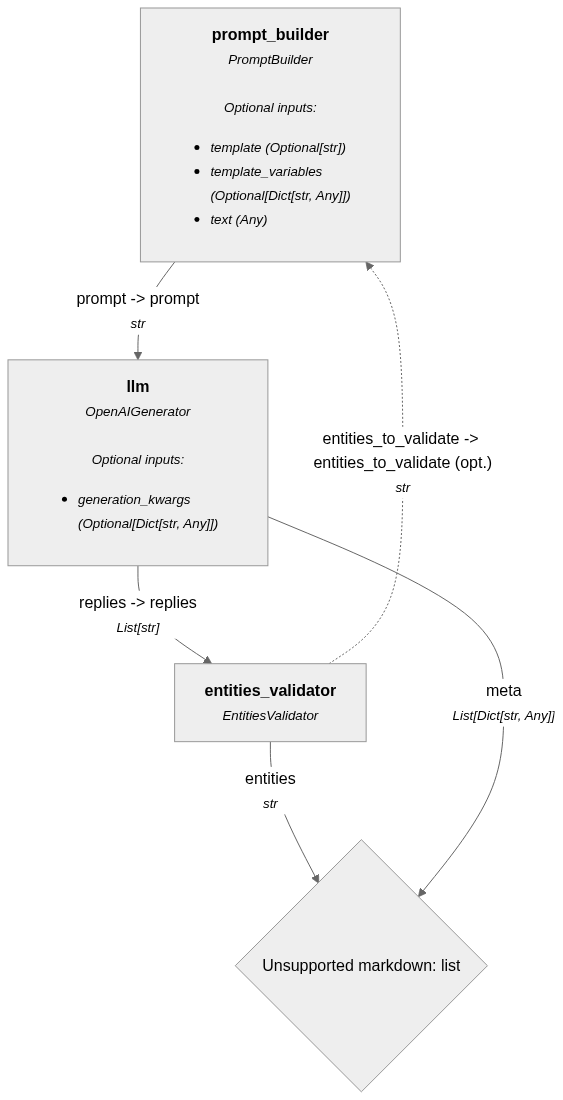

In [13]:
self_reflecting_agent.show()

In [14]:
text = """
Istanbul is the largest city in Turkey, straddling the Bosporus Strait, 
the boundary between Europe and Asia. It is considered the country's economic, 
cultural and historic capital. The city has a population of over 15 million residents, 
comprising 19% of the population of Turkey,[4] and is the most populous city in Europe 
and the world's fifteenth-largest city."""

result = self_reflecting_agent.run({"prompt_builder": {"text": text}})
print(Fore.GREEN + result['entities_validator']['entities'])

Reflecting on entities
 {
    "Location": ["Istanbul", "Turkey", "Bosporus Strait", "Europe", "Asia", "Europe"],
    "Quantity": ["over 15 million", "19%"],
    "Organization": ["Turkey"]
}
Reflecting on entities
 {
    "Person": [],
    "Location": [
        "Istanbul",
        "Turkey",
        "Bosporus Strait",
        "Europe",
        "Asia"
    ],
    "Date": []
}
Reflecting on entities
 {
    "Person": [],
    "Location": ["Istanbul", "Turkey", "Bosporus Strait", "Europe", "Asia"],
    "Date": []
}
Reflecting on entities
 {
    "Person": [],
    "Location": [
        "Istanbul",
        "Turkey",
        "Europe",
        "Asia"
    ],
    "Date": []
}
Location: Istanbul, Turkey, Europe, Asia
Person: 
Date: 



In [15]:
text = """
Stefano: Hey all, let's start the all hands for June 6th 2024
Geoff: Thanks, I'll kick it off with a request. Could we please add persistent memory to the Chroma document store.
Stefano: Easy enough, I can add that to the feature requests. What else?
Julain: There's a bug, some BM25 algorithms return negative scores and we filter them out from the results by default.
Instead, we should probably check which algorithm is being used and keep results with negative scores accordingly.
Esmail: Before we end this call, we should add a new Generator component for LlamaCpp in the next release.
Tuana: Thanks all, I think we're done here, we can create some issues in GitHub about these."""

result = self_reflecting_agent.run({"prompt_builder": {"text": text}})
print(Fore.GREEN + result['entities_validator']['entities'])

Reflecting on entities
 {
    "Person": ["Stefano", "Geoff", "Julain", "Esmail", "Tuana"],
    "Date": ["June 6th 2024"]
}
{
  "Person": [
    "Stefano",
    "Geoff",
    "Julian",
    "Esmail",
    "Tuana"
  ],
  "Location": [],
  "Date": [
    "June 6th 2024"
  ]
} 

